In [109]:
#Import GPT2Tokenizer to use

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [110]:
import pickle
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from IPython.display import display
import sympy as sp
import urllib
sp.init_printing(use_latex=True)
import matplotlib.pyplot as plt
import textwrap
#import os
#os.environ['LD_LIBRARY_PATH']='/opt/conda/lib'

In [111]:
#Transormer block setup
#Initializes multi-head attention, feed-forward network, layer normalization
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"), #feed-forward
             keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [112]:
#Initialize transformer, multi-head-attention, ff net, and mask
class GPTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(GPTransformerBlock, self).__init__(**kwargs)
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, training):
        y = x
        y = self.layernorm1(y, training=training)
        y = self.att(y, y,
                     use_causal_mask = True,
                     training=training)
        y = self.dropout1(y, training=training)
        x += y
        y = x
        y = self.layernorm2(y, training=training)
        y = self.ffn(y, training=training)
        y = self.dropout2(y, training=training)
        return x + y

In [113]:
#Positional encoding for self-attention

# Source pulled from KerasNLP: https://github.com/keras-team/keras-nlp/blob/v0.4.1/keras_nlp/layers/sine_position_encoding.py#L22
class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    This layer optionally accepts `tf.RaggedTensor`s as inputs to process
    batches of sequences of different lengths. The one ragged dimension must be
    the dimension that corresponds to the sequence, that is, the penultimate
    dimension.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        if isinstance(inputs, tf.RaggedTensor):
            bounding_shape = inputs.bounding_shape()
            position_embeddings = (
                self._compute_trim_and_broadcast_position_embeddings(
                    bounding_shape,
                )
            )
            # then apply row lengths to recreate the same ragged shape as inputs
            return tf.RaggedTensor.from_tensor(
                position_embeddings,
                inputs.nested_row_lengths(),
            )
        else:
            return self._compute_trim_and_broadcast_position_embeddings(
                tf.shape(inputs),
            )

    def _compute_trim_and_broadcast_position_embeddings(self, shape):
        seq_length = shape[-2]
        hidden_size = shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

In [114]:
#Token and position embedding to allow the model to differentiate token positions, for self-attention
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, input_dim, output_dim, **kwargs):
        super(MaskedTokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = keras.layers.Embedding(input_dim=input_dim,
                                                output_dim=output_dim,
                                                mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
                                              output_dim=output_dim,
                                              mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [115]:
#Sine position embeddings, for self-attention
class MaskedTokenAndSinePositionEmbedding(keras.layers.Layer):
    def __init__(self, input_dim, output_dim, max_wavelength=10000,**kwargs):
        super(MaskedTokenAndSinePositionEmbedding, self).__init__(**kwargs)
        self.token_emb = keras.layers.Embedding(input_dim=input_dim,
                                                output_dim=output_dim,
                                                mask_zero=True)
        self.pos_emb = SinePositionEncoding(max_wavelength=max_wavelength)

    def call(self, x):
        mask = tf.expand_dims(tf.sign(x),-1)
        x = self.token_emb(x)
        positions = self.pos_emb(x)
        positions = positions * mask
        return x + positions

In [116]:
# Custom masked loss/accuracy functions
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


In [117]:
# !wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/Austen.txt

In [118]:
segment_size = 20
model_length = 10*segment_size
batch_size = 100

In [151]:
with open('Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
text = []
j = 0
for i in range(len(lines)-1):
    if lines[i] == '':
        line = ' '.join(lines[j:i])
        if line != '':
            text = text + [line[k:k+model_length-2] for k in range(0, len(line), model_length-2)]
            # text = text + [line]
        j = i+1

In [152]:
len(text)

In [153]:
text[0]

'Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world'

In [154]:
# Subset? - All of the data will take some time...
n_seq = len(text)
n_seq = 1000
split_point = int(n_seq * 0.8)
text = text[:n_seq]
np.random.shuffle(text) # In-place modification
max_length = np.max([len(i) for i in text])+2 # Start+stop
max_length

200

In [170]:
#Encode / Decode tokens using built-in functions
#Not sure about max length
def encode_seq(x, tokenizer#, max_length=0
              ):
    # String to token IDs
    return tokenizer.encode(x)

def decode_seq(x, tokenizer):
    # Token IDs to string
    return tokenizer.decode(x)


In [177]:
temp = encode_seq(text[0], tokenizer#, max_length
                 )
print(*temp)

1 46 8951 284 11148 683 0 2011 13674 48805 11 644 466 345 1612 30 4231 345 287 597 4719 355 284 326 30 314 1807 960 4360 314 4123 534 27322 11 3737 314 423 587 739 257 7457 13 314 3729 423 587 29789


In [178]:
decoded_temp = decode_seq(temp, tokenizer)
print(decoded_temp)

"Ought to refuse him! My dear Harriet, what do you mean? Are you in any doubt as to that? I thought—but I beg your pardon, perhaps I have been under a mistake. I certainly have been misunderstanding


In [179]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, max_length, batch_size=32, **kwargs):
        super(DataGenerator, self).__init__(**kwargs)
        'Initialization'
        self.batch_size = batch_size
        self.data = data # a handle only...
        self.indices = np.arange(self.data[0].shape[0])
        self.max_length = max_length
        self.idx = 0
        self.on_epoch_end()

    def __len__(self):
        'The number of batches per epoch'
        return int(np.floor(self.data[0].shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one (enumerated) batch of data'
        # Generate indices for a batch and grab batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(indices)

    def __data_generation(self, ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Generate data
        x = tf.convert_to_tensor(self.data[0][ids],dtype=tf.int32)
        y = tf.convert_to_tensor(self.data[1][ids],dtype=tf.int32)
        return x, y

    def on_epoch_end(self):
        return np.random.shuffle(self.indices)

    ## Needed for TF Dataset conversion...
    def output_signature(self):
        sig = self[0]
        return (tf.TensorSpec.from_tensor(sig[0]),
                tf.TensorSpec.from_tensor(sig[1]))

In [169]:
#Encode in batches
X = np.vstack([encode_seq(x,tokenizer#,max_length + (segment_size - (max_length-1) % segment_size)
                         ) for x in text])
training = DataGenerator((X[:split_point,:-1],
                          X[:split_point,1:]),model_length,batch_size)
validation = DataGenerator((X[split_point:,:-1],
                            X[split_point:,1:]),model_length,batch_size)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 47 and the array at index 1 has size 46

In [141]:
len(training)

In [180]:
len(temp[0])

TypeError: object of type 'int' has no len()

In [181]:
temp_length = len(temp)
temp = np.array([temp_length+1 for i in temp])
temp

array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48])

In [182]:
np.array([np.random.randint(i) for i in temp])-100

array([-79, -77, -80, -86, -66, -93, -88, -96, -85, -83, -66, -62, -56,
       -70, -66, -66, -58, -93, -86, -67, -86, -97, -83, -96, -79, -62,
       -79, -58, -65, -69, -66, -79, -57, -57, -84, -78, -65, -96, -55,
       -77, -63, -95, -75, -83, -81, -98, -99])

In [183]:
my_batch = training[0]
my_batch[0].shape

TensorShape([100, 200])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 masked_token_and_sine_posit  (None, None, 128)        9088      
 ion_embedding_2 (MaskedToke                                     
 nAndSinePositionEmbedding)                                      
                                                                 
 gp_transformer_block_10 (GP  (None, None, 128)        857600    
 TransformerBlock)                                               
                                                                 
 gp_transformer_block_11 (GP  (None, None, 128)        857600    
 TransformerBlock)                                               
                                                                 
 gp_transformer_block_12 (GP  (None, None, 128)        8576

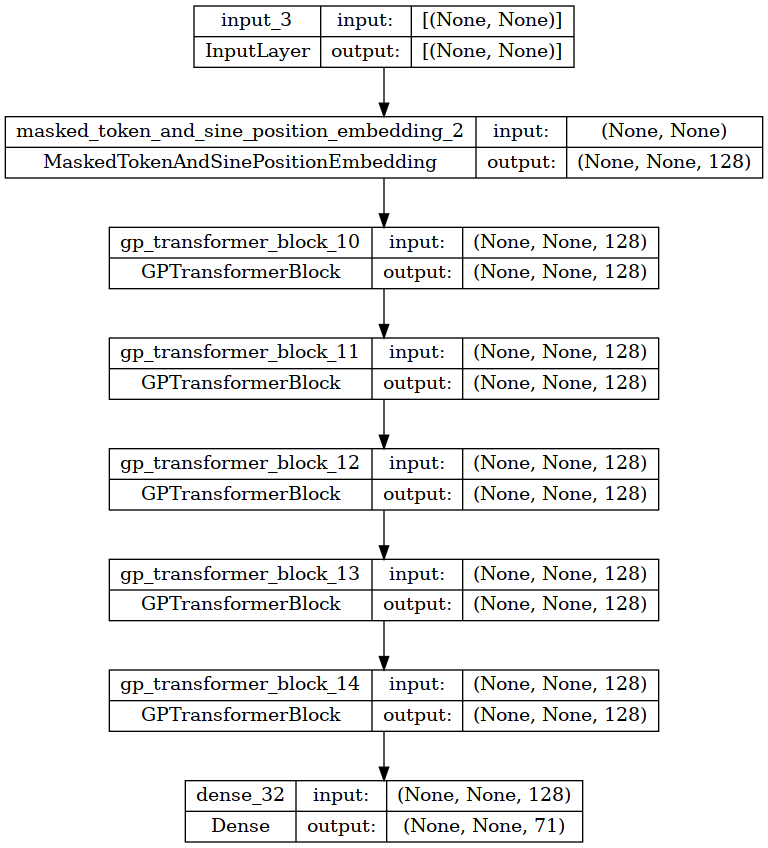

In [184]:
#Finalize and compile model
n_tokens = len(i_to_c_pandp)
embedding_size = 128
stack = 5
num_heads = 12
memory_size = segment_size * 3

y = x = keras.layers.Input((None,))
y = MaskedTokenAndSinePositionEmbedding(input_dim=n_tokens,
                                        output_dim=embedding_size)(y)
for _ in range(stack):
    y = GPTransformerBlock(embedding_size,
                           num_heads,
                           embedding_size*2)(y)

y = keras.layers.Dense(n_tokens)(y)

model = keras.Model(x,y)
model.compile(loss=MaskedSparseCategoricalCrossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=MaskedSparseCategoricalAccuracy)
model.summary()
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [147]:
epochs = 300
history = model.fit(training,
                    epochs=epochs,
                    validation_data=validation,
                    verbose=1)

Epoch 1/300


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/errors_impl.py(273): __init__
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py(54): quick_execute
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/function.py(499): call
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/function.py(1862): _call_flat
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/function.py(2496): __call__
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/def_function.py(980): _call
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/def_function.py(915): __call__
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /opt/conda/lib/python3.10/site-packages/keras/engine/training.py(1564): fit
  /opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py(65): error_handler
  /tmp/ipykernel_396/135394589.py(2): <module>
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3433): run_code
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3373): run_ast_nodes
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3194): run_cell_async
  /opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2995): _run_cell
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2940): run_cell
  /opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py(528): run_cell
  /opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py(383): do_execute
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(730): execute_request
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(499): process_one
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /opt/conda/lib/python3.10/asyncio/events.py(80): _run
  /opt/conda/lib/python3.10/asyncio/base_events.py(1899): _run_once
  /opt/conda/lib/python3.10/asyncio/base_events.py(603): run_forever
  /opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py(199): start
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py(712): start
  /opt/conda/lib/python3.10/site-packages/traitlets/config/application.py(985): launch_instance
  /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /opt/conda/lib/python3.10/runpy.py(86): _run_code
  /opt/conda/lib/python3.10/runpy.py(196): _run_module_as_main
